
# Reproduction overview

In this notebook, we reproduce the results for the square-lattice Ising model from:
* Nature link: https://www.nature.com/articles/nphys4035
* arxiv link: https://arxiv.org/abs/1605.01735

We aim to reproduce Fig. 1b and 1c from the arxiv version of the paper.
* Fig. 1b (arXiv) corresponds to Fig. 1a (Nature). The Nature version includes error bars in the mean neuron output estimation, and we incorporate them here as well.
* Fig. 1c (arXiv) corresponds to Fig. 1b (Nature). This is the same plot but with the temperature axis rescaled. We reproduce the arXiv version (unscaled).

We evaluate the model for the following system sizes: $L\in\{ 10, 20, 30, 40, 60\}$, as in the Nature version.

Each model is trained separately for each value of $L$.
Training was performed in a different notebook (training_notebook.ipynb), and here we focus exclusively on loading pretrained models and evaluating their performance to reproduce the figures.

In [37]:
import torch
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt

import utils, helper_functions

In [38]:
L_LIST = [10, 20, 30, 40, 60]

In [39]:
device = "cpu"

# Model preparation

We load all pretrained models corresponding to the system sizes $L$.

Each model was trained separately using the architecture described in the paper:
* Imput dimension: $L^2$ spins,
* One hidden layer with 100 sigmoid neurons,
* Two-output sigmoid layer (phase classification).

Here, we construct the same architecture for each value of $L$, load the corresponding pretrained weights from disk, and evaluate the accuracy on the test dataset.

The dictionary `models` stores all pretrained networks:

- **Keys:** integer system sizes \( `L` \) ,
- **Values:** the corresponding PyTorch models trained on an $L \times L$ lattice,

In [41]:
models = {} # Dictionary storing pretrained models indexed by system size L

for L in L_LIST:
    # Set up PyTorch Models
    models[L] = nn.Sequential(
        nn.Linear(L**2, 100),
        nn.Sigmoid(),
        nn.Linear(100, 2),
        nn.Sigmoid(),
    )

    # Load pre-trained weights
    models[L].load_state_dict( torch.load(os.path.join("models", f"L={L}.pth"), weights_only=True))

    # Load data needed to compute accuracy
    _, Xtest, _, ytest, _ = utils.get_data(L, "data", "cpu")

    # Compute accuracy
    accuracy = helper_functions.compute_accuracy(models[L], Xtest, ytest)

    print(f"L = {L} | Accuracy = {accuracy:.4f}")

L = 10 | Accuracy = 0.9320
L = 20 | Accuracy = 0.9627
L = 30 | Accuracy = 0.9720
L = 40 | Accuracy = 0.9785
L = 60 | Accuracy = 0.9825


The accuracies should increase to reproduce the reuslts from the paper.

## Reproduction of Fig. 1b from arxiv

In this section, we reproduce Fig. 1b from the arXiv preprint of Carrasquilla & Melko (2017).
Our goal is to plot the average output of each neuron in the network as a function of temperature for each system size $L$.

For each value of $L$, we store the results in dictionaries:

We aim to plot the output of the neural network vs temperature.
The results will be stored in dictionaries
* keys: values of system size $L$,
* values: arrays containing the corresponding quantities (mean output and standard error).

This ensures the results are organized cleanly and can be used later for plotting the full figure.

In [42]:
means_neuron_1 = {}
means_neuron_2 = {}
errors_neuron_1 = {}
errors_neuron_2 = {}

for L in L_LIST:
    # Get data
    _, Xtest, _, _, temperatures = utils.get_data(L, "data", "cpu")

    # Perform inference
    mean_n1, error_n1, mean_n2, error_n2 = helper_functions.plot_output_layer(models[L], Xtest, temperatures, make_plot=False)
    means_neuron_1[L] = mean_n1
    means_neuron_2[L] = mean_n2
    errors_neuron_1[L] = error_n1
    errors_neuron_2[L] = error_n2

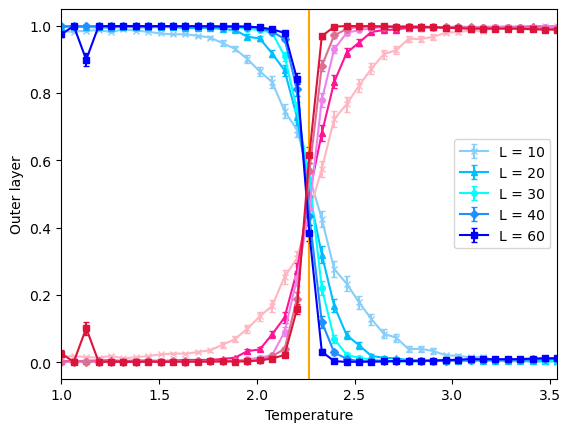

In [43]:
plt.errorbar(temperatures, means_neuron_1[10], yerr=errors_neuron_1[10],
             fmt = "-x", ms = 4, color="lightskyblue", capsize = 2, label = "L = 10")
plt.errorbar(temperatures, means_neuron_2[10], yerr=errors_neuron_2[10],
             fmt = "-x", ms = 4, color="lightpink", capsize = 2)

plt.errorbar(temperatures, means_neuron_1[20], yerr=errors_neuron_1[20],
             fmt = "-^", ms = 4, color="deepskyblue", capsize = 2, label = "L = 20")
plt.errorbar(temperatures, means_neuron_2[20], yerr=errors_neuron_2[20],
             fmt = "-^", ms = 4, color="deeppink", capsize = 2)

plt.errorbar(temperatures, means_neuron_1[30], yerr=errors_neuron_1[30],
             fmt = "-o", ms = 4, color="cyan", capsize = 2, label = "L = 30")
plt.errorbar(temperatures, means_neuron_2[30], yerr=errors_neuron_2[30],
             fmt = "-o", ms = 4, color="violet", capsize = 2)

plt.errorbar(temperatures, means_neuron_1[40], yerr=errors_neuron_1[40],
             fmt = "-D", ms = 4, color="dodgerblue", capsize = 2, label = "L = 40")
plt.errorbar(temperatures, means_neuron_2[40], yerr=errors_neuron_2[40],
             fmt = "-D", ms = 4, color="palevioletred", capsize = 2)

plt.errorbar(temperatures, means_neuron_1[60], yerr=errors_neuron_1[60],
             fmt = "-s", ms = 4, color="blue", capsize = 2, label = "L = 60")
plt.errorbar(temperatures, means_neuron_2[60], yerr=errors_neuron_2[60],
             fmt = "-s", ms = 4, color="crimson", capsize = 2)

plt.axvline(x = 2 / np.log(1 + np.sqrt(2)), color = "orange")

plt.legend()
plt.xlim( temperatures[0], temperatures[-1] )
plt.xlabel("Temperature")
plt.ylabel("Outer layer")
plt.show()

In [ ]:
Blue curves correspond to neuron 1, red curves to neuron 2.

For each system size $L$, we visualize how the two output neurons respond to configurations sampled at different temperatures.
* Neuron 1 activates predominantly for low-temperature (ordered) configurations. Its output should start close to 1 at small $T$ and then decrease toward $0$ as $T$ crosses the critical region.
* Neuron 2 behaves in the opposite way: it activates for high-temperature (disordered) configurations, staying near 0 at low $T$ and rising toward 1 at high $T$.

# Reproduction of fig 1c from the arXiv version

In this section, we reproduce Fig. 1c from the arXiv preprint of Carrasquilla & Melko (2017).
This figure shows the classification accuracy of the neural network as a function of temperature, for different lattice sizes.

For each $L$, we evaluate the pretrained model on the test dataset and compute the accuracy separately at every temperature point. The results are stored in a dictionary:

* **Keys**: system sizes $L$
* **Values**: arrays of accuracy values corresponding to each temperature

We then plot all accuracy curves on a single figure to compare how classification performance sharpens as the lattice size increases.

In [44]:
accuracies = {}

for L in L_LIST:
    # Get data
    _, Xtest, _, ytest, temperatures = utils.get_data(L, "data", "cpu")

    # Get accuracy
    accuracies[L] = helper_functions.plot_accuracy_vs_temperature(models[L], Xtest, ytest, temperatures, samples_per_temperature=250, make_plot=False)

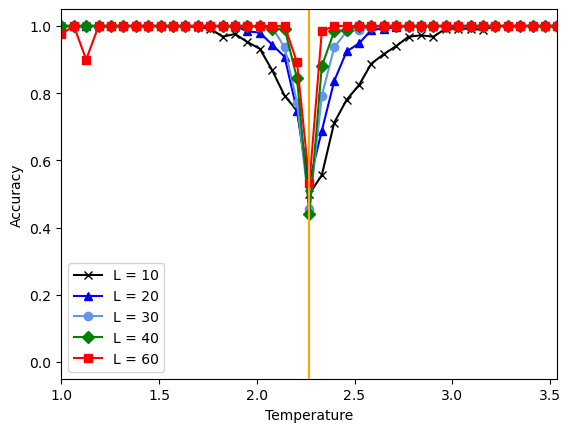

In [45]:
plt.plot(temperatures, accuracies[10], "-x", label = "L = 10", color = "black")
plt.plot(temperatures, accuracies[20], "-^", label = "L = 20", color = "blue")
plt.plot(temperatures, accuracies[30], "-o", label = "L = 30", color = "cornflowerblue")
plt.plot(temperatures, accuracies[40], "-D", label = "L = 40", color = "green")
plt.plot(temperatures, accuracies[60], "-s", label = "L = 60", color = "red")

plt.axvline(x = 2 / np.log(1 + np.sqrt(2)), color = "orange")
plt.xlim( temperatures[0], temperatures[-1] )
plt.xlabel("Temperature")
plt.ylim(-0.05, 1.05)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

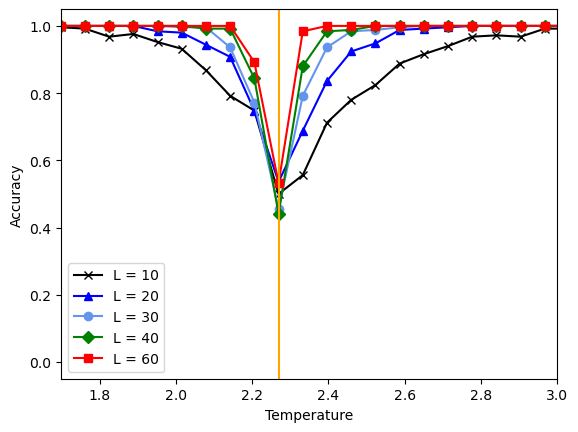

In [46]:
plt.plot(temperatures, accuracies[10], "-x", label = "L = 10", color = "black")
plt.plot(temperatures, accuracies[20], "-^", label = "L = 20", color = "blue")
plt.plot(temperatures, accuracies[30], "-o", label = "L = 30", color = "cornflowerblue")
plt.plot(temperatures, accuracies[40], "-D", label = "L = 40", color = "green")
plt.plot(temperatures, accuracies[60], "-s", label = "L = 60", color = "red")

plt.axvline(x = 2 / np.log(1 + np.sqrt(2)), color = "orange")
plt.xlim( 1.7, 3 )
plt.xlabel("Temperature")
plt.ylim(-0.05, 1.05)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

For each lattice size $L$, the curve shows the classification accuracy of the pretrained neural network as a function of temperature. At low temperatures, the network should predict the ordered (ferromagnetic) phase with very high accuracy. At high temperatures, it should predict the disordered (paramagnetic) phase equally well.
Around the critical temperature the accuracy dips because configurations become harder to classify. 

As $L$ increases, this dip becomes sharper, reflecting the increased separation between phases in larger systems.